In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import seaborn as sns
from meegkit import dss

from pycrostates.preprocessing import extract_gfp_peaks
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew


In [2]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [30]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\Data\texas_data")
file = data_folder / r"C:\Users\workbench\eirik_master\Data\texas_data\EEG_Cat_Study4_Resting_S19.bdf"

raw = mne.io.read_raw_bdf(file, verbose=False, preload=True)
print(raw.info)
#Be carefull that artifact electrodes are not included in the average calc.
print(raw.info['ch_names'])
raw.drop_channels(['M1', 'M2', 'NAS', 'LVEOG', 'RVEOG', 'LHEOG', 'RHEOG', 'NFpz'])
raw.set_montage('biosemi64')
print(raw.info)
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')

#bridged, dist = mne.preprocessing.compute_bridged_electrodes(raw)


raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=30)
raw_down_sampled = raw_lowpass.copy().resample(sfreq=60, verbose=False)
print(raw_down_sampled.info)
#I should maybe downsample, and maybe do it first for computational efficiency. The only thing is that then almost all the data will be in simpochs, so maybe I need stricter limits for gfp peakes.
#Bad segments can maybe be identified with Christoffers algorithm, anything else? I want to do this at the end of the pipeline I think.

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 72 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 52.0 Hz
 meas_date: 2016-08-03 16:41:54 UTC
 nchan: 73
 projs: []
 sfreq: 256.0 Hz
 subject_info: 1 item (dict)
>
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'M1', 'M2', 'NAS', 'LVEOG', 'RVEOG', 'LHEOG', 'RHEOG', 'NFpz', 'Status']
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 1.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2016-08-03 16:41:54 UTC
 nchan: 65
 projs: []
 sfreq: 60.0 Hz
 subject_info: 1 item (dict)
>


C:\Users\workbench\AppData\Local\Temp\ipykernel_21604\1301016745.py:20: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw_down_sampled = raw_lowpass.copy().resample(sfreq=60, verbose=False)


In [3]:
print(raw_down_sampled.get_data().shape)

(65, 30420)


In [4]:
events = mne.find_events(raw_down_sampled, stim_channel='Status')

Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
970 events found on stim channel Status
Event IDs: [  101   201 65536 65790]


In [5]:
for i in events:
    print(i)

[   39 65536 65790]
[161   0 101]
[191   0 101]
[221   0 101]
[251   0 101]
[281   0 101]
[311   0 101]
[341   0 101]
[371   0 101]
[401   0 101]
[431   0 101]
[461   0 101]
[491   0 101]
[521   0 101]
[551   0 101]
[581   0 101]
[611   0 101]
[641   0 101]
[671   0 101]
[701   0 101]
[731   0 101]
[761   0 101]
[791   0 101]
[821   0 101]
[851   0 101]
[881   0 101]
[911   0 101]
[941   0 101]
[971   0 101]
[1001    0  101]
[1031    0  101]
[1061    0  101]
[1091    0  101]
[1121    0  101]
[1151    0  101]
[1181    0  101]
[1211    0  101]
[1241    0  101]
[1271    0  101]
[1301    0  101]
[1331    0  101]
[1361    0  101]
[1391    0  101]
[1421    0  101]
[1451    0  101]
[1481    0  101]
[1511    0  101]
[1541    0  101]
[1571    0  101]
[1601    0  101]
[1631    0  101]
[1661    0  101]
[1691    0  101]
[1721    0  101]
[1751    0  101]
[1781    0  101]
[1811    0  101]
[1841    0  101]
[1871    0  101]
[1901    0  101]
[1931    0  101]
[1961    0  101]
[1991    0  101]
[2021    0

In [24]:
baseline = (0, 0)  # means from the first instant to t = 0
ones_epochs = mne.Epochs(raw_down_sampled, events, [101, 201], tmin=0, tmax=0.48, baseline=None, preload=True)

Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 30 original time points ...
0 bad epochs dropped


In [25]:
ones_epochs.drop_channels("Status")
mne.set_eeg_reference(ones_epochs, copy=False, verbose=False)

(<Epochs |  960 events (all good), 0 – 0.483333 s, baseline off, ~14.2 MB, data loaded,
  '101': 480
  '201': 480>,
 array([[ 1.38178505e-06, -5.11807973e-06, -7.99976644e-07, ...,
         -9.74190900e-07, -1.65750629e-06, -4.19200101e-06],
        [-3.08262761e-06,  1.62340167e-06,  3.22255481e-06, ...,
          1.73893477e-07, -3.71968290e-06, -6.51243932e-06],
        [-2.54959897e-06, -1.28936314e-06, -3.52931466e-06, ...,
         -8.62243870e-07,  2.88726807e-06, -7.97962774e-07],
        ...,
        [ 3.13733909e-06,  2.21134594e-06,  5.77281576e-06, ...,
          5.13388189e-06,  4.39633190e-06, -1.88221799e-06],
        [ 2.69053082e-06, -1.16578255e-06, -4.24220662e-06, ...,
         -2.52946790e-06, -1.91318220e-06, -3.12512285e-06],
        [-4.76351951e-07, -6.41799045e-06, -3.22208301e-06, ...,
          1.89147805e-06,  4.35085172e-07,  1.14474277e-06]]))

In [26]:
print(ones_epochs.get_data().shape)

(960, 64, 30)


C:\Users\workbench\AppData\Local\Temp\ipykernel_21604\1600552724.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(ones_epochs.get_data().shape)


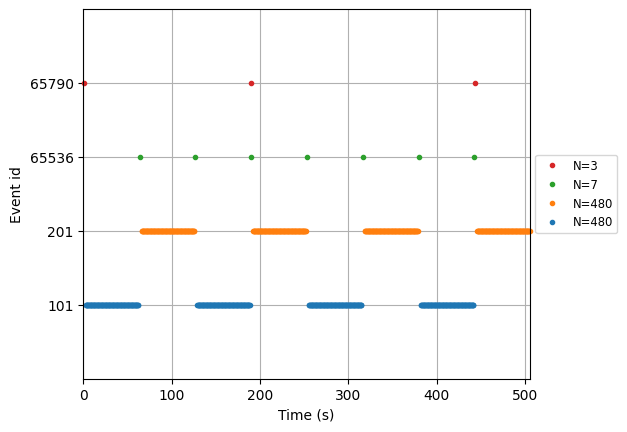

In [27]:
fig = mne.viz.plot_events(
    events, sfreq=raw_down_sampled.info["sfreq"], first_samp=raw_down_sampled.first_samp
)

In [28]:
#From mne toturial

def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5 * n_channels]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [1.5, 3.5],
        "theta": [4, 7.5],
        "alpha": [8, 13],
        "beta": [13.5, 25],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0, method='welch')
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    #psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

test = eeg_power_band(ones_epochs)


Effective window size : 0.500 (s)


In [29]:
print(test.shape)

(960, 256)


In [30]:
def gfp_normed_diss_data(indices, data, gfp):
    all_inx = np.arange(data.shape[1])
    unorderd_adj_indices = np.array([indices, (indices-1)]).flatten()
    anti_adj_indices = np.delete(all_inx, unorderd_adj_indices)
    all_inx = np.arange(data.shape[1])
    adj_indices = np.delete(all_inx, anti_adj_indices)

    indexed_data = data[:, adj_indices]
    indexed_gfp = gfp[adj_indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

def gfp_normed_diss_data2(indices, data, gfp):
    indexed_data = data[:, indices]
    indexed_gfp = gfp[indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

In [162]:
def diss(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices), data.shape[0]))
    for t in range(0, len(indices)*2, 2):
        diss[int(t/2), :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t+1])
    return diss

def diss2(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data2(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices)-1, data.shape[0]))
    for t in range(1, len(indices)):
        diss[t-1, :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t-1])
    return diss

In [163]:
def epoched_stability(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        d = diss(data, gfp, indices)
        stability[e] = np.mean(np.sqrt(np.mean(d, 1)))
    return stability

def epoched_stability2(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stability = np.ndarray(shape=(epochs_array.shape[0]))
    switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    significant_switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    peaks = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        d = diss2(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        freq = 0
        sfreq = 0
        for s in individual_map_stability:
            if s > 0:
                freq += 1
            if s > 0.4:
                sfreq += 1
        switching_freq[e] = freq
        significant_switching_freq[e] = sfreq
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stability[e] = np.mean(for_convex)
        peaks[e] = len(indices)
    return stability, switching_freq, convex_stability, significant_switching_freq, peaks

Bad epoch idenfication - based on topographic stability

In [164]:
#ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, overlap=0.5)

In [165]:
print(ones_epochs.get_data().shape)

(960, 64, 256)


In [166]:
epoched_stability, epoched_switching_freq, convex_stabilty, significant_switching_freq, peaks = epoched_stability2(ones_epochs)

Plots to investigate exclusion of epocs not following our assumptions.

Epoch averaged DISS

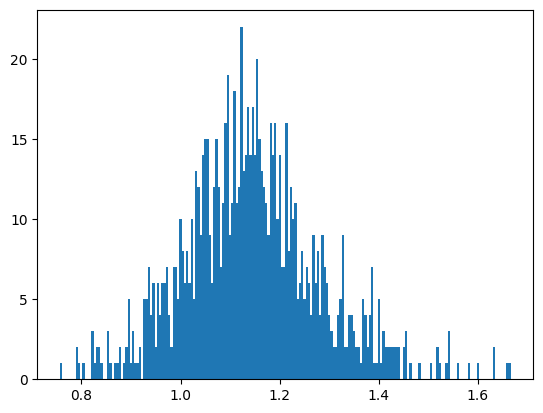

In [167]:
plt.hist(convex_stabilty, bins=200)
plt.show()

This is kind of a nonesesical plot as both 2 and 0 represents maximal stability. Stability values are therefor corrupted by averaging. Hovewer, some timepoints idicating high stability by ways of low values are clearly sepreated from the rest. These are epochs of high amplitude, low frequency noise. These are not corrupted by averageing as there is no polarity inversion happening, making them very distinct in the distribution.

In [168]:
timepoints = np.where(convex_stabilty<0.6)[0]
print((timepoints)/2)

[]


100.5-101 is this periode of high amplitude, low frequency noise. 158 and 210.5-211.5 is eyeblink artifacts I think. 229.5-230 not so sure. There are other periodes of eyeblink artifacts more apparent then the last one here.

Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

In [169]:
plt.hist(epoched_stability, bins=200)
plt.show()

Not a lot of good stability values, prob. because we have a lot of bad electrodes.

In [170]:
timepoints = np.where(epoched_stability<0.25)[0]
print((timepoints)/2)

[29.  39.  39.5 59.5]


The most instable epochs do not look bad to me as expected. The most stable epochs looks like contains a lot of high amplitude alpha waves, but also the epoch with high amplitude, low frequency noise (stability value of approx 0.75 as expected).

Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

In [171]:
plt.hist(epoched_switching_freq, bins=36)
plt.show()

Here we A LOT of epochs with high switching rate, over 30 was outliers in the relative clean EEG, though prob. not directly comparable this difference is big. It seems when there are a lot of electrodes with high frequency noise, most epoch characteristics of this type mimics muscle artifacts in clean EEG. 

In [172]:
timepoints = np.where(epoched_switching_freq<5)[0]
print((timepoints)/2)

[]


Bad epochs of high apml low freq noise a the bottom as for clean EEG.

The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

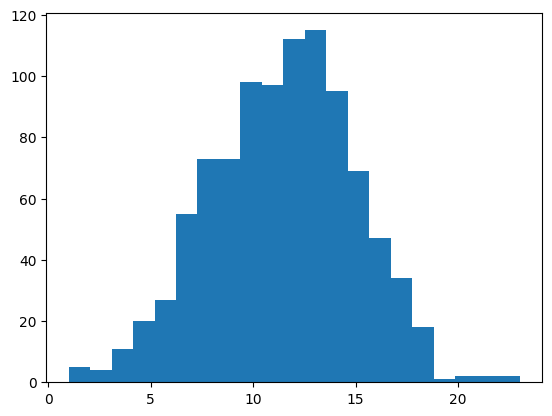

In [173]:
plt.hist(significant_switching_freq, bins=21)
plt.show()

When looking at "significant" polarity inversions we see a lot of clean epocs also showing zero switching. This natural as several epochs will be in low GFP areas with low overall topographic stability. Also the general drop here in switching is HUGE.

Number of GFP peaks for each epoch

In [174]:
plt.hist(peaks, bins=21)
plt.show()

We also see an abnormaly high amount of GFP peaks. All being below 50 in the cleaner sample. Now we think there arnt that many muscle artifacts, so again this is prob due to the high number of electrodes with high freq noise.

Looking at scatter plot between swithcing frequencies and number of GFP peaks

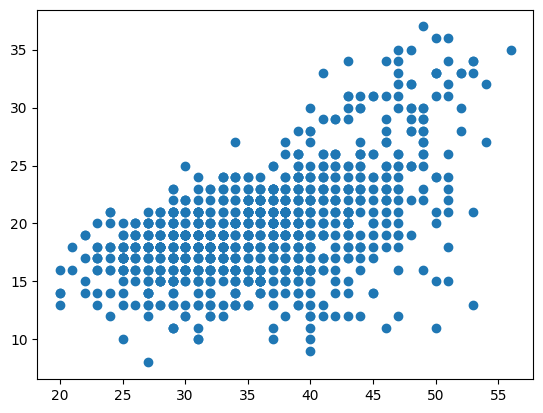

In [175]:
plt.scatter(peaks, epoched_switching_freq)
plt.show()

In [176]:
idx = np.where((epoched_switching_freq < 2))[0]
print((idx-1)/2)

[]


In [177]:
plt.scatter(peaks, significant_switching_freq)
plt.show()

This plot is also not good for identifying muscle artifacts.

In [178]:
idx = np.where((peaks > 50))[0]
print((idx-1)/2)

idx = np.where((peaks < 28) & (significant_switching_freq < 9))[0]
print((idx-1)/2)

idx = np.where((significant_switching_freq == 0))[0]
print((idx-1)/2)

[ -0.5   6.5   7.   10.   18.   18.5  19.   19.5  20.5  24.   26.5  28.5
  30.   30.5  31.   36.   58.5  59.  121.5 122.  365.5 395.5 396. ]
[ 85.5  97.  104.5 106.  112.  197.5 319.5 331. ]
[]


What is becoming apparent is that moments of high amplitude low frequency noise don't experience a lot of polarity inversion. Hovewer these moments can show a varity of gfp peak numbers, mixing with none anomolous momments. Also in this section we see that not only do muscle artifacts experience a lot of GFP peaks but they also see few polarity inversions, but more inversions that moments of low stability EEG (that is clean). We might get a nice convex distribution here if we have EEG with a lot of muscle artifacts.

Looking at average absoluteDISS in relation to switching frequencies.

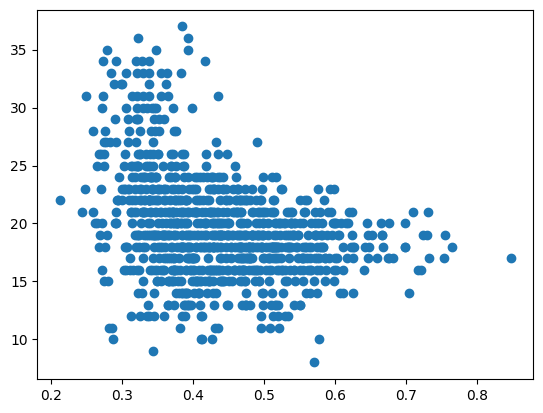

In [179]:
plt.scatter(epoched_stability, epoched_switching_freq)
plt.show()

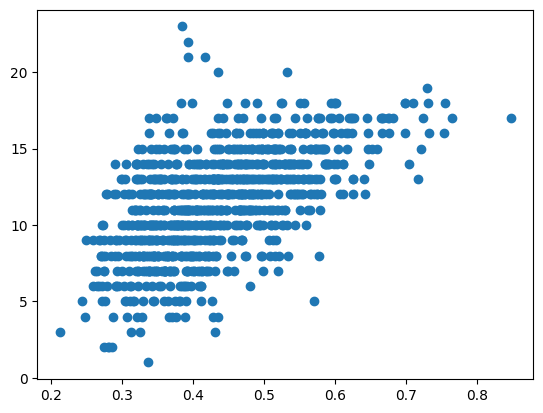

In [180]:
plt.scatter(epoched_stability, significant_switching_freq)
plt.show()

So here we see more clearly that very stable points not having a lot of "significant" polarity inversion sticks out as ouliers in this otherwise exponential looking distribution.

In [181]:
idx = np.where((epoched_stability > 0.5) & (significant_switching_freq < 5))[0]
print((idx-1)/2)

[]


210 looks like clear eye artifact

Same but with average DISS

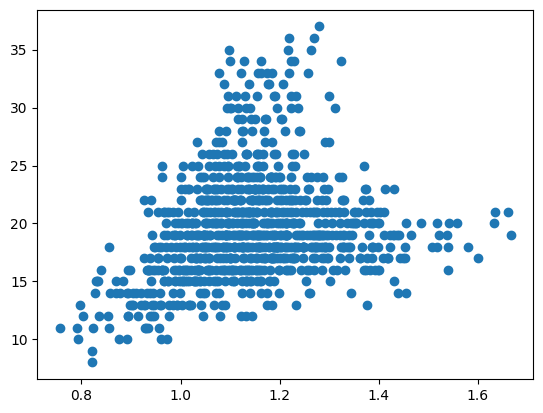

In [182]:
plt.scatter(convex_stabilty, epoched_switching_freq)
plt.show()

In [183]:
plt.scatter(convex_stabilty, significant_switching_freq)
plt.show()

Nothing more to say here, a bit harder to deleaniate the moments of high aplitume low frequency noise.

In [184]:
print(epoched_stability[4*2], convex_stabilty[4*2], epoched_switching_freq[4*2], significant_switching_freq[4*2])

0.36194527595818987 1.1775613595140677 32.0 17.0


In [185]:
print(epoched_stability[int(109.5*2)+1], convex_stabilty[int(109.5*2)+1], epoched_switching_freq[int(109.5*2)+1], significant_switching_freq[int(109.5*2)+1])

0.3941048923204585 1.1505222044660486 23.0 12.0


Scatter of the two stability types

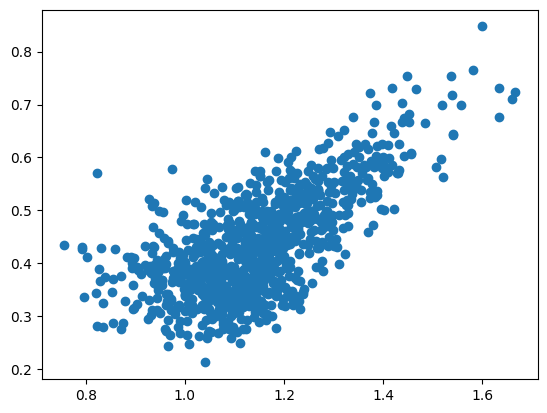

In [186]:
plt.scatter(convex_stabilty, epoched_stability)
plt.show()

In [187]:
idx = np.where((epoched_stability>0.4) & (convex_stabilty<0.75))[0]
print(idx)
print((idx)/2)

[]
[]


Very interestingly alot of these epochs looks like they contain eye artifacts, in addition to the very bad epoch described several times.

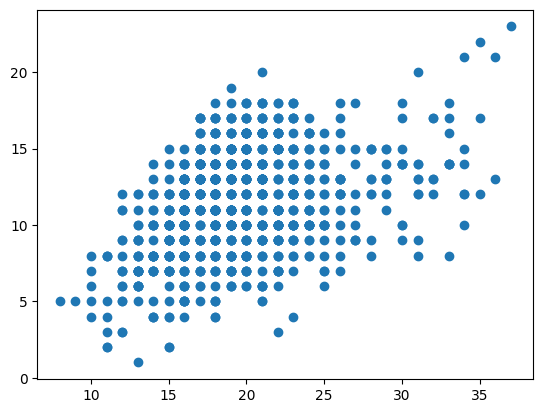

In [188]:
plt.scatter(epoched_switching_freq, significant_switching_freq)
plt.show()

In [189]:
idx = np.where((epoched_switching_freq > 25) & (significant_switching_freq < 15))[0]
print((idx-1)/2)

[ -0.5   0.    4.    5.5   6.    7.    9.5  10.   11.   16.   18.   18.5
  19.   19.5  21.5  22.   22.5  23.   24.   24.5  25.5  26.   26.5  27.
  27.5  28.   28.5  29.   29.5  30.   31.   31.5  32.   34.   34.5  35.
  39.5  40.   46.5  53.5 122.  123.  124.  127.5 128.  129.5 143.  143.5
 163.  164.5 242.  242.5 245.  247.  293.5 297.  297.5 298.  298.5 299.
 371.5 389.5 391. ]


In [190]:
channel_names = np.array(raw_down_sampled.info['ch_names'])

In [191]:
data, indices, gfp, info_mne  = microstates_clean(raw_down_sampled, standardize_eeg=False, normalize=False, gfp_method='l2')
print(indices.shape, gfp.shape, data.shape)
gfp_peakes = gfp[indices]
print(gfp_peakes.shape)
#new_indices = np.argpartition(gfp_peakes, -1000)[-1000:]
#new_indices = np.sort(new_indices)
#print(new_indices)
#print(new_indices.shape)
gfp_data = data[:, indices]#[:, new_indices]
#print(neuro_gfp_data.shape)

(19095,) (130816,) (65, 130816)
(19095,)


1020.9557248335005


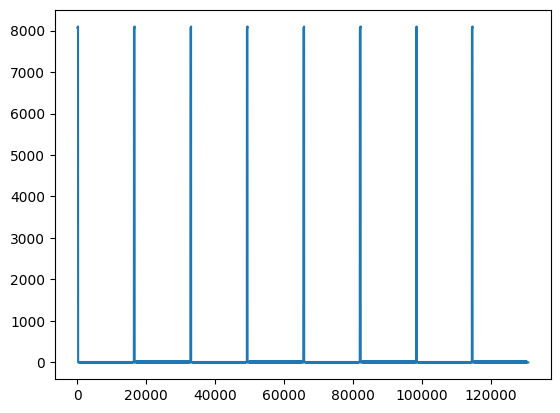

In [192]:
print(np.std(gfp_peakes))
plt.plot(gfp)
plt.show()

In [193]:
plt.hist(gfp_peakes, bins=1000)
plt.show()

In [194]:
print(kurtosis(gfp_peakes))

56.4132559063424


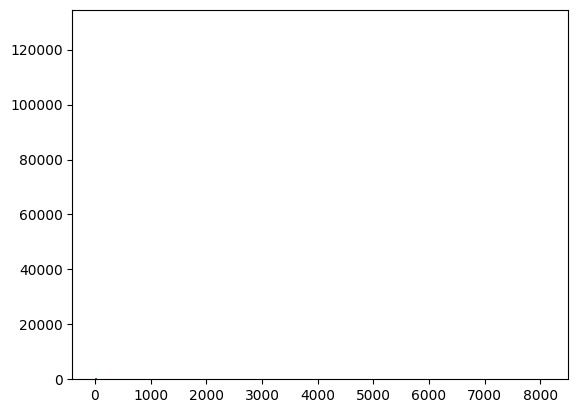

In [195]:
plt.hist(gfp, bins=1000)
plt.show()

In [196]:
print(kurtosis(gfp))
print(np.std(gfp))
print(np.mean(gfp))
print(np.mean(gfp) + np.std(gfp)*5)

79.7366349218482
871.1131670401181
95.36671425993588
4450.932549460526


In [197]:
print(np.where(gfp_peakes>0.00004)[0])
#indices = np.delete(indices, np.arange(3183, 3258, 1))
#gfp_peakes = np.delete(gfp_peakes, np.arange(3183, 3258, 1))
indices = np.delete(indices, np.where(gfp_peakes>0.00004)[0])
gfp_peakes = np.delete(gfp_peakes, np.where(gfp_peakes>0.00004)[0])


[    0     1     2 ... 19002 19024 19040]


In [198]:
print(np.std(gfp_peakes))
plt.plot(gfp_peakes)
plt.show()

4.530980852513798e-06


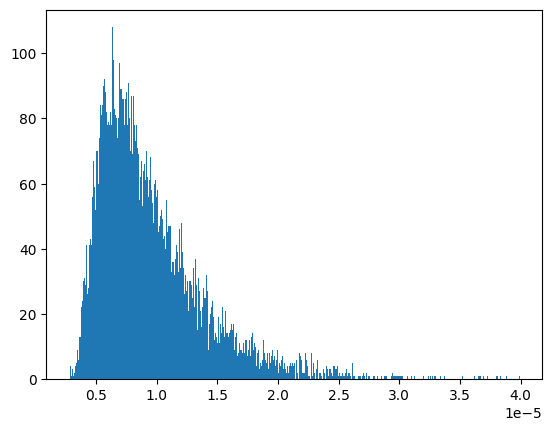

In [199]:
plt.hist(gfp_peakes, bins=1000)
plt.show()

In [200]:
print(kurtosis(gfp_peakes))

4.503230523337034


In [201]:
print(indices.shape)

(17810,)


In [202]:
print(np.average(gfp))
print(np.std(gfp))

95.36671425993588
871.1131670401181


In [203]:
gfp_peakes = gfp[indices]
print(gfp_peakes.shape)
gfp_data = data[:, indices]
print(gfp_data.shape)

(17810,)
(65, 17810)


In [204]:
print(np.std(gfp_peakes))
plt.plot(gfp_peakes[3210:3253])
plt.show()
#Something wierd here for sure...

4.530980852513798e-06


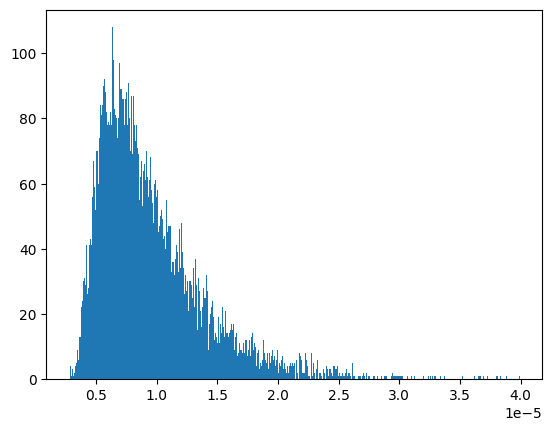

In [205]:
plt.hist(gfp_peakes, bins=1000)
plt.show()

In [206]:
print(kurtosis(gfp))

79.7366349218482


In [207]:
print(np.std(gfp_peakes))
plt.plot(gfp_peakes)
plt.show()
#Something wierd here for sure...

4.530980852513798e-06


In [208]:
"""gfp_peakes = extract_gfp_peaks(raw_down_sampled, min_peak_distance=1)
print(gfp_peakes.get_data().shape)
top_indices = np.argpartition(np.std(gfp_peakes.get_data(), axis=0), -6003)[-6003:]
print(top_indices.shape)
gfp_data = gfp_peakes.get_data()[:, top_indices]
print(gfp_data.shape)"""

'gfp_peakes = extract_gfp_peaks(raw_down_sampled, min_peak_distance=1)\nprint(gfp_peakes.get_data().shape)\ntop_indices = np.argpartition(np.std(gfp_peakes.get_data(), axis=0), -6003)[-6003:]\nprint(top_indices.shape)\ngfp_data = gfp_peakes.get_data()[:, top_indices]\nprint(gfp_data.shape)'

In [209]:
all_inx = np.arange(raw_down_sampled.get_data().shape[1])
drop = np.delete(all_inx, indices)
sim_indices = np.array([indices, (indices-1)]).flatten()
all_inx = np.arange(raw_down_sampled.get_data().shape[1])
simpochs_indices = np.delete(all_inx, sim_indices)


In [210]:
print(len(all_inx))
print(indices.shape)
print(sim_indices.shape)

130816
(17810,)
(35620,)


In [211]:
print(drop.shape)
print(simpochs_indices.shape) #Something wierd here...

(113006,)
(95196,)


In [212]:
print(indices)
print(sim_indices)

[   186    194    196 ... 130800 130803 130806]
[   186    194    196 ... 130799 130802 130805]


In [213]:
epochs = mne.make_fixed_length_epochs(raw_down_sampled, duration = 1/raw_down_sampled.info['sfreq'], verbose=False, preload=True)

In [214]:
print(epochs.info)

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 1.0 Hz
 lowpass: 52.0 Hz
 meas_date: 2016-03-09 13:37:54 UTC
 nchan: 65
 projs: []
 sfreq: 256.0 Hz
 subject_info: 1 item (dict)
>


In [215]:
epochs.drop(drop)

Dropped 113006 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 22

<Epochs |  17810 events (all good), 0 – 0 s, baseline off, ~8.9 MB, data loaded,
 '1': 17810>

In [216]:
simpochs = mne.make_fixed_length_epochs(raw_down_sampled, duration = 1/raw_down_sampled.info['sfreq'], verbose=False, preload=True)

In [217]:
simpochs.drop(simpochs_indices)

Dropped 95196 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 187, 188, 189, 190, 191, 192, 197, 198, 199, 200, 201, 202, 203, 204, 207, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 225, 226, 227, 228, 229, 230, 233

<Epochs |  35620 events (all good), 0 – 0 s, baseline off, ~17.8 MB, data loaded,
 '1': 35620>

In [218]:
ica = mne.preprocessing.ICA(max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True),
    )

In [219]:
ica.fit(epochs)
#Do I feed enough data to ICA?

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 64 components
Computing Extended Infomax ICA
Fitting ICA took 29.9s.


<ICA | epochs decomposition, method: infomax (fit in 135 iterations on 17810 samples), 64 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

Creating RawArray with float64 data, n_channels=64, n_times=130816
    Range : 0 ... 130815 =      0.000 ...   510.996 secs
Ready.


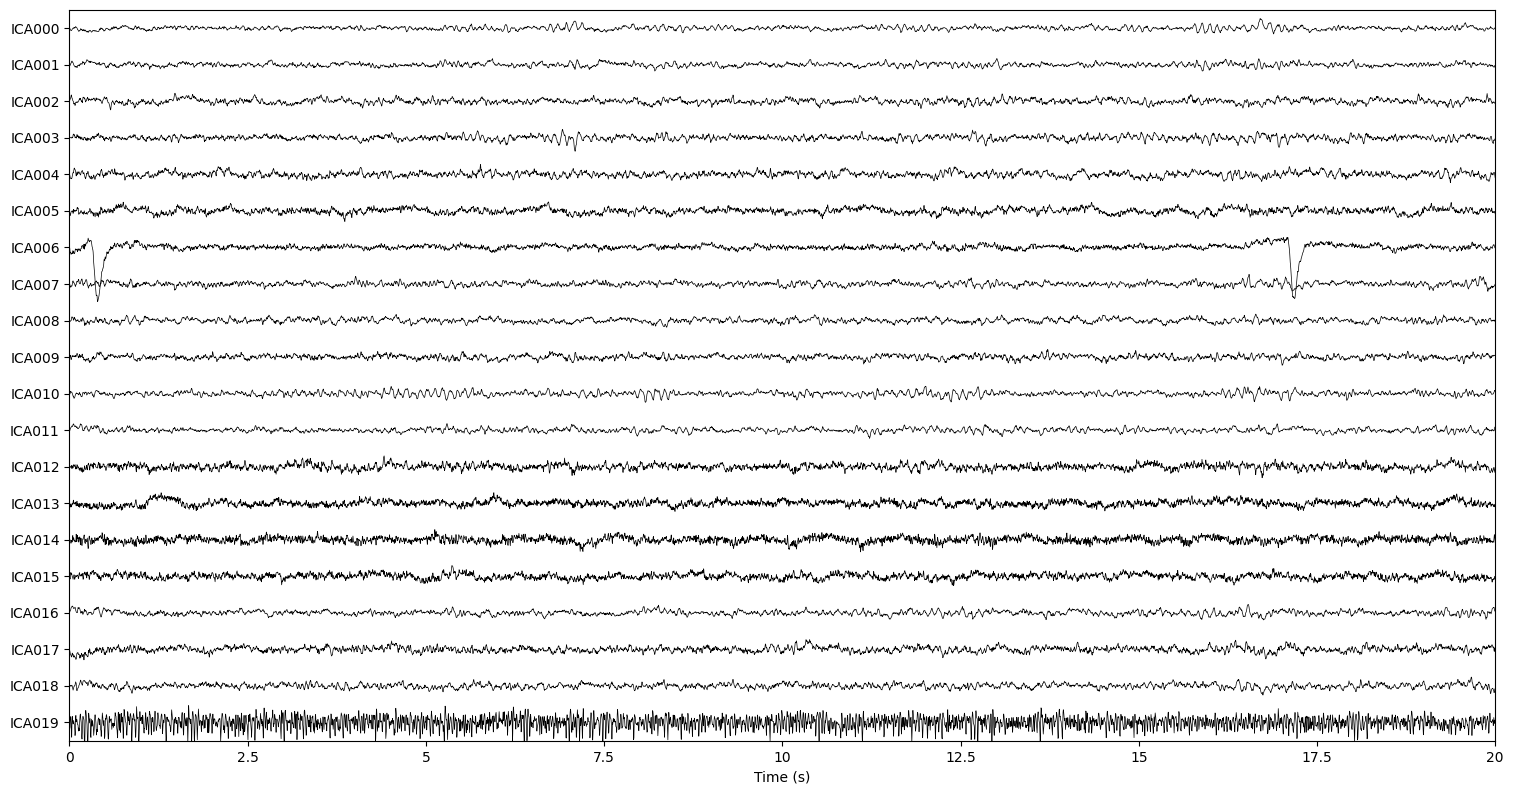

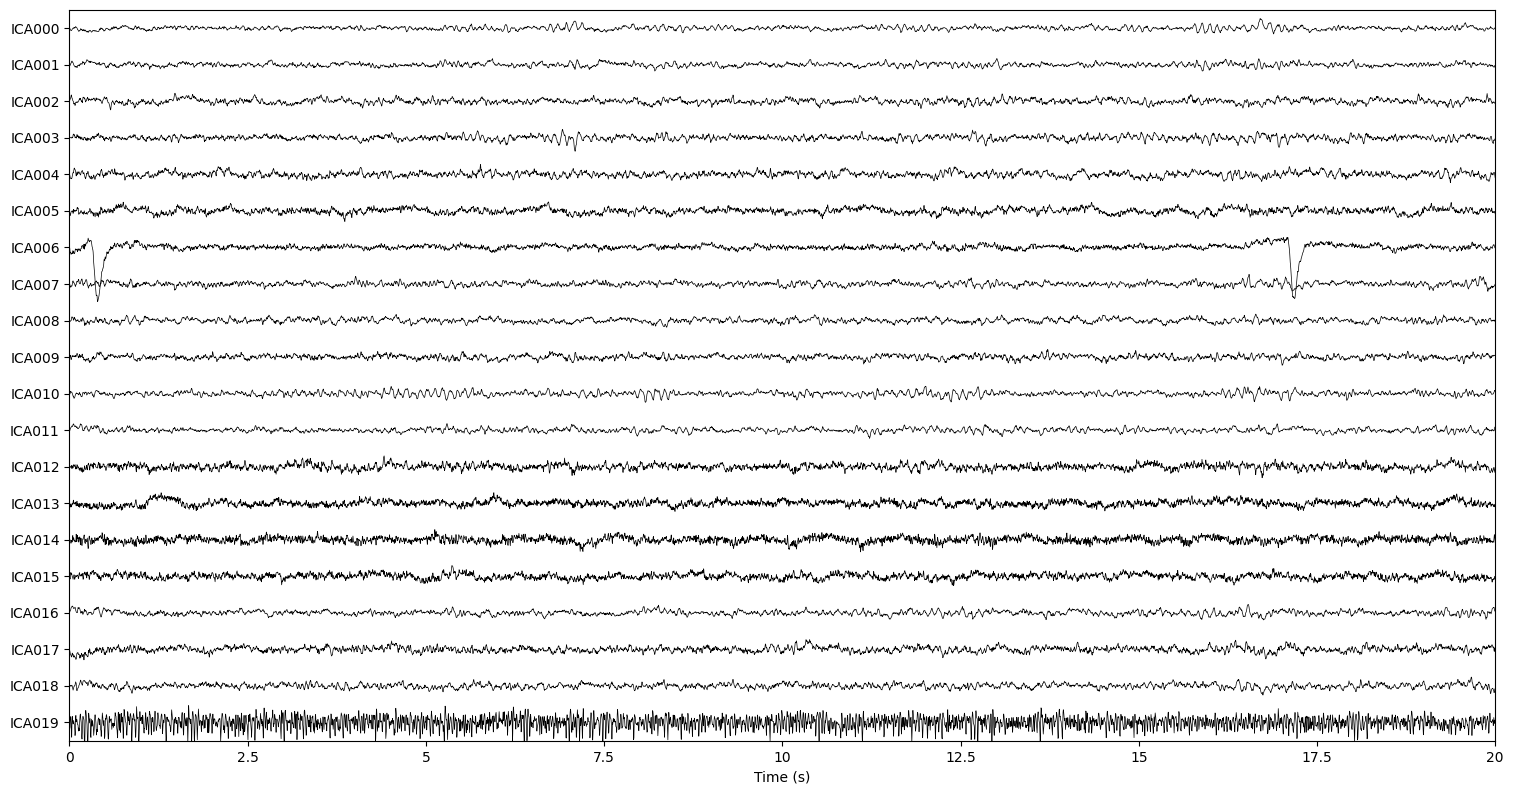

In [220]:
ica.plot_sources(raw_down_sampled, show_scrollbars=False, show=True)

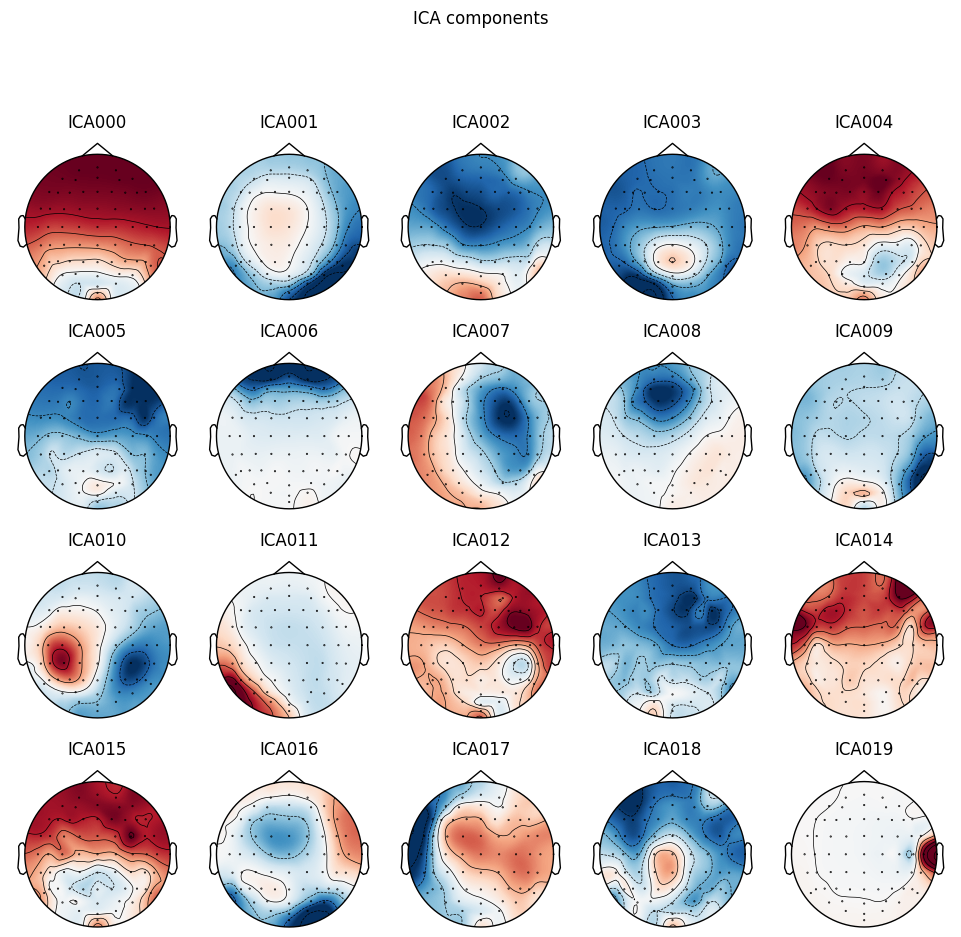

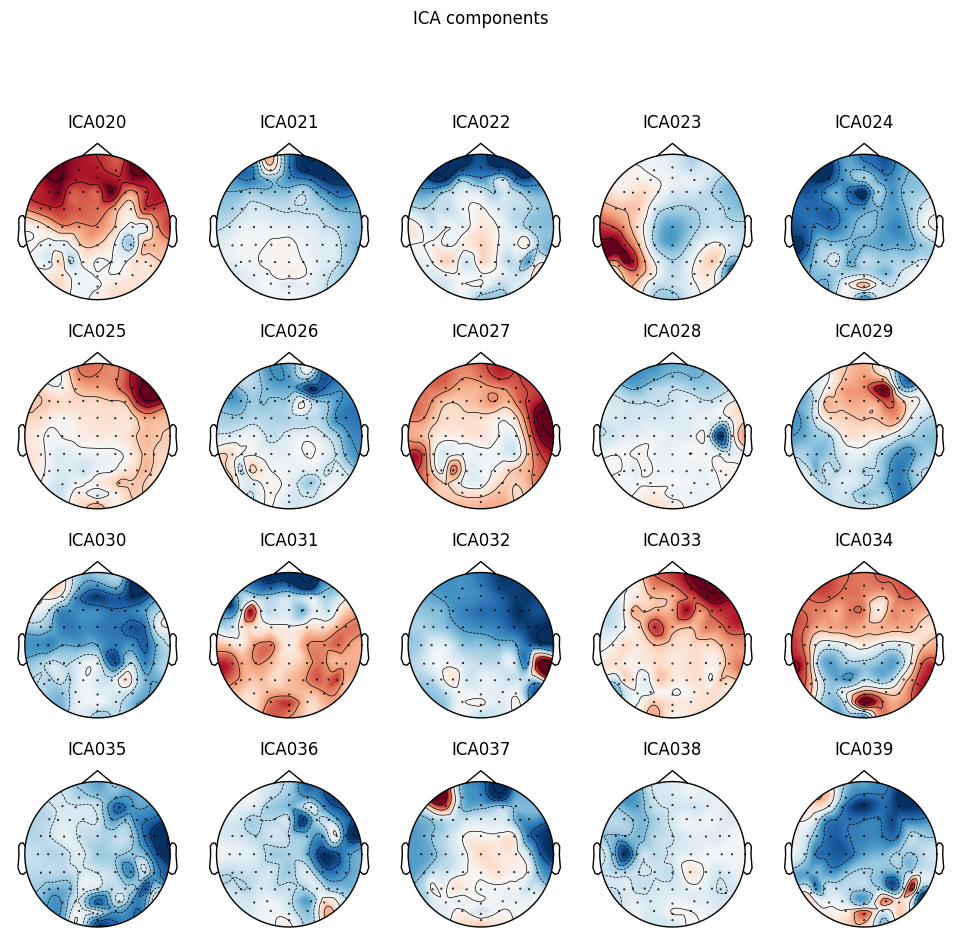

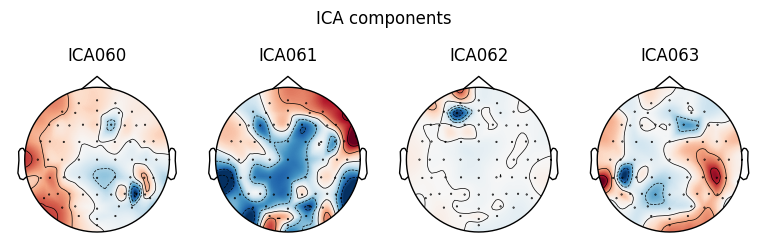

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>]

In [221]:
ica.plot_components()
#Something wierd with component 1 here for sure, hence the wish for bad segment excluder. 

In [222]:
ic_labels = label_components(raw_down_sampled, ica, method='iclabel')

C:\Users\Gulbr\AppData\Local\Temp\ipykernel_25072\1066216419.py:1: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_down_sampled, ica, method='iclabel')
C:\Users\Gulbr\AppData\Local\Temp\ipykernel_25072\1066216419.py:1: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_down_sampled, ica, method='iclabel')


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [223]:
print(ic_labels)

{'y_pred_proba': array([0.8640319 , 0.8440752 , 0.9647071 , 0.7774248 , 0.49802738,
       0.61730206, 0.9780544 , 0.9948627 , 0.8232097 , 0.79281175,
       0.9987361 , 0.9691231 , 0.8166795 , 0.9396117 , 0.7333234 ,
       0.5503887 , 0.8456029 , 0.8592119 , 0.869336  , 0.9662436 ,
       0.78115207, 0.5955419 , 0.50307673, 0.49587345, 0.7720827 ,
       0.35098246, 0.92972064, 0.91245925, 0.76112324, 0.61769176,
       0.4814436 , 0.69133514, 0.5476517 , 0.6570336 , 0.56147194,
       0.8322602 , 0.76178956, 0.9441261 , 0.93267155, 0.87558454,
       0.54733115, 0.858479  , 0.98362726, 0.89732236, 0.90217006,
       0.96733   , 0.40235615, 0.38357455, 0.5644959 , 0.91122353,
       0.6385888 , 0.8376641 , 0.6802552 , 0.9673566 , 0.91172487,
       0.5000553 , 0.57626754, 0.571603  , 0.4753968 , 0.70317376,
       0.39306977, 0.6978307 , 0.60482955, 0.6160288 ], dtype=float32), 'labels': ['brain', 'brain', 'brain', 'brain', 'brain', 'line noise', 'eye blink', 'brain', 'brain', 'brain

In [224]:
s = ica.get_sources(epochs)

In [225]:
s.get_data().shape

(17810, 64, 1)

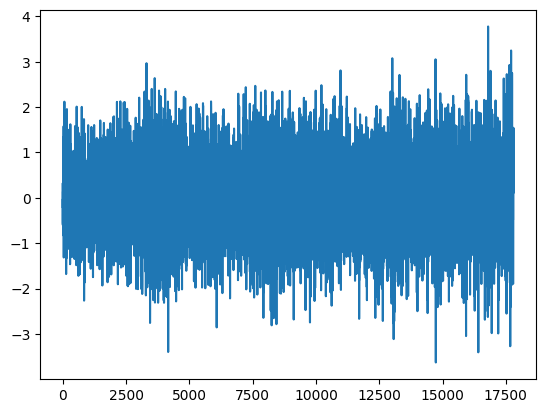

In [226]:
plt.plot(s.get_data()[:, 4, 0])
plt.show()

In [227]:
print(s.get_data()[1, 0, 0], s.get_data()[1, 1, 0], s.get_data()[1, 2, 0], s.get_data()[1, 3, 0], s.get_data()[1, 4, 0], s.get_data()[1, 5, 0], s.get_data()[1, 6, 0])

0.5124838777713915 -0.015878905084365156 -1.09816533058545 -0.34081960116337834 0.32437142841055333 1.8732611932537693 1.0588377281091508


In [228]:
print(simpochs.get_data().shape)

(35620, 65, 1)


ICA charachteristics

In [229]:
from scipy.stats import median_abs_deviation

In [230]:
comps = ica.get_components()
comp_gfp_mad = median_abs_deviation(comps, 0)
comp_gfp_std = np.std(comps, 0)

In [231]:

print(comp_gfp_mad.shape)

(64,)


In [232]:
print(comp_gfp_mad)

[0.30300266 0.17062241 0.11783616 0.05050248 0.15353699 0.09366361
 0.03742342 0.16043007 0.08524159 0.03538145 0.12082798 0.05587642
 0.0806714  0.05127767 0.05166597 0.09869868 0.05516545 0.07167093
 0.0493155  0.01157426 0.05516834 0.03770103 0.04055552 0.05130598
 0.02390017 0.03933948 0.03592436 0.03693086 0.02419751 0.05082604
 0.03342369 0.03342555 0.03716466 0.02383595 0.0406483  0.02024235
 0.02064084 0.0346946  0.01662705 0.0276997  0.02155527 0.03617876
 0.02773709 0.03066466 0.03294399 0.0454628  0.02669843 0.03120293
 0.02850671 0.03367766 0.00993533 0.02544796 0.03168742 0.01809908
 0.03507538 0.01997017 0.01995325 0.01352653 0.01741732 0.01112145
 0.01630863 0.0254561  0.00474092 0.01764478]


In [233]:
print(comp_gfp_std)

[0.43469444 0.25553774 0.17841568 0.10425563 0.15621206 0.11043414
 0.15736355 0.18166618 0.15027845 0.10559623 0.15824886 0.16350166
 0.09793877 0.06983087 0.0801649  0.09878536 0.1159387  0.11012317
 0.06831981 0.10347207 0.07095389 0.06457561 0.06664812 0.08853118
 0.03913649 0.07176089 0.05806245 0.05637302 0.05914375 0.07924178
 0.04066871 0.06489031 0.0508537  0.05155988 0.06535887 0.03584741
 0.03990309 0.05565677 0.04080274 0.04201386 0.03269467 0.04686934
 0.04903358 0.05495762 0.05453941 0.05510942 0.04595231 0.04828911
 0.03902298 0.03857814 0.04012354 0.04646777 0.04752171 0.04538884
 0.04652858 0.03284712 0.03088608 0.03663743 0.0262819  0.02868111
 0.03191889 0.02875976 0.02698146 0.02925137]


the square root of the mean of squared differences between GFP normalized electrodes.

In [234]:
print(data.shape)

(65, 130816)


In [235]:
d = diss2(data, gfp, indices)
print(d.shape)

(17809, 65)


In [236]:
stability = np.sqrt(np.mean(d, axis=0))
print(stability.shape)

(65,)


In [237]:
print(stability)

[2.41305614 2.39036611 2.39302614 2.36139637 2.32160827 2.31260404
 2.31210043 2.24384005 2.15715039 2.15848311 2.24388416 1.77942647
 1.70267071 1.74400081 1.91937871 1.64242274 1.3473868  1.2637435
 1.16379461 0.79869394 0.79910458 1.05099685 1.41450402 1.85821753
 1.27125042 0.59226929 1.1534862  1.56161565 1.10148746 0.58172491
 0.63461784 1.21557836 2.41911216 2.4533957  2.44987839 2.42862684
 2.41074398 2.37013661 2.39580898 2.37678076 2.44025616 2.4536805
 2.46765169 2.41156502 2.31800541 2.27018177 2.26161572 1.87583242
 1.86189887 2.03780838 2.23174583 3.13442494 2.08106198 1.88775141
 1.71530429 1.38290656 0.95485087 1.36563455 1.60465184 1.84784994
 2.14341562 1.75876912 1.06439796 1.50022184 0.        ]


In [238]:
order = np.argsort(stability)
print(channel_names[order])

['Status' 'POz' 'PO3' 'Pz' 'P1' 'P3' 'P2' 'P5' 'PO4' 'Oz' 'O1' 'CP1' 'CPz'
 'CP3' 'PO7' 'CP5' 'P4' 'CP2' 'P7' 'O2' 'Iz' 'P6' 'TP7' 'C3' 'CP4' 'C5'
 'PO8' 'C1' 'P8' 'P9' 'C2' 'Cz' 'CP6' 'T7' 'C4' 'TP8' 'P10' 'FC5' 'FC3'
 'C6' 'FT7' 'FC1' 'FCz' 'FC2' 'F7' 'F5' 'FC4' 'F3' 'F1' 'Fz' 'F4' 'AF7'
 'AF3' 'F2' 'AFz' 'FC6' 'Fp1' 'Fpz' 'AF4' 'F6' 'AF8' 'Fp2' 'F8' 'FT8' 'T8']


In [239]:
plt.hist(stability, bins=64)
plt.xlabel('Average squared GFP normalized channel difference')
plt.ylabel('Observations')
plt.title('Channel stability')
plt.show()

In [240]:
print(np.std(stability))
plt.plot(stability)
plt.show()

0.6198350898505661


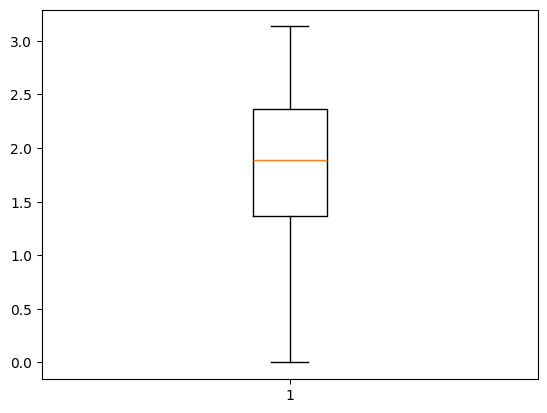

In [241]:
plt.boxplot(stability)
plt.show()

In [242]:
def remove_bad(mne_epoch_object, channel_name):
    raw = mne_epoch_object.copy()
    raw.drop_channels(channel_name)
    return raw

In [243]:
def leav_one_out(epochs_object):
    epoched_stability, _, _, _, _ = epoched_stability2(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _, _, _, _ = epoched_stability2(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [244]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\texas_data")
file = data_folder / "EEG_Cat_Study4_Resting_S16.bdf"

raw = mne.io.read_raw_bdf(file, verbose=False, preload=True)
print(raw.info)
#Be carefull that artifact electrodes are not included in the average calc.
print(raw.info['ch_names'])
raw.drop_channels(['M1', 'M2', 'NAS', 'LVEOG', 'RVEOG', 'LHEOG', 'RHEOG', 'NFpz', 'Status'])
raw.set_montage('biosemi64')
print(raw.info)
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')

#bridged, dist = mne.preprocessing.compute_bridged_electrodes(raw)


raw_down_sampled = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
mne.set_eeg_reference(raw_down_sampled, copy=False, verbose=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Gulbr\\MasterOppgave\\texas_data\\EEG_Cat_Study4_Resting_S16.bdf'

In [ ]:
channel_names = np.array(raw_down_sampled.info['ch_names'])

In [ ]:
channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)
#channelstab_epochs.drop([100, 101, 102, 108, 109, 110, 111])
test1 = leav_one_out(channelstab_epochs)
channelstab_epochs.drop([6, 7, 8, 56, 57, 58, 324, 400, 410, 411, 420])
test2 = leav_one_out(channelstab_epochs)

Dropped 11 epochs: 6, 7, 8, 56, 57, 58, 324, 400, 410, 411, 420


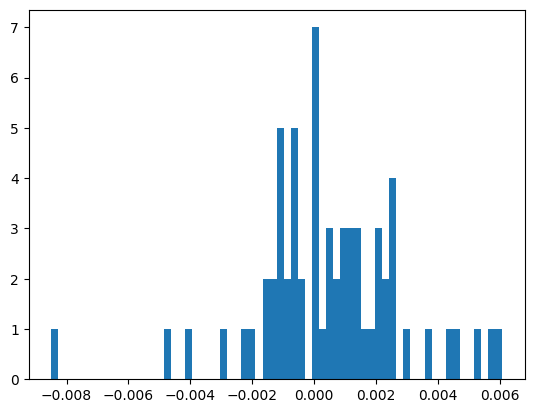

In [ ]:
plt.hist(test1, bins=64)
plt.show()

In [ ]:
order = np.argsort(test1)
print(channel_names[order])
print(kurtosis(test1))
print(skew(test1))

['T8' 'FT8' 'C4' 'FC6' 'FT7' 'T7' 'F8' 'FC4' 'AF7' 'C6' 'P10' 'C5' 'CP6'
 'F6' 'AF8' 'CPz' 'CP4' 'F7' 'TP8' 'C2' 'CP2' 'TP7' 'P1' 'Fp2' 'FC5' 'CP5'
 'Cz' 'P9' 'P6' 'P8' 'Fp1' 'CP3' 'C1' 'Fpz' 'F2' 'P4' 'C3' 'P2' 'CP1' 'F4'
 'FC3' 'AF4' 'P7' 'FC2' 'PO8' 'FCz' 'Iz' 'FC1' 'AF3' 'F1' 'F3' 'AFz' 'Fz'
 'P5' 'Pz' 'F5' 'P3' 'PO4' 'O2' 'POz' 'PO7' 'Oz' 'PO3' 'O1']
2.3203859475339614
-0.4646322151342405


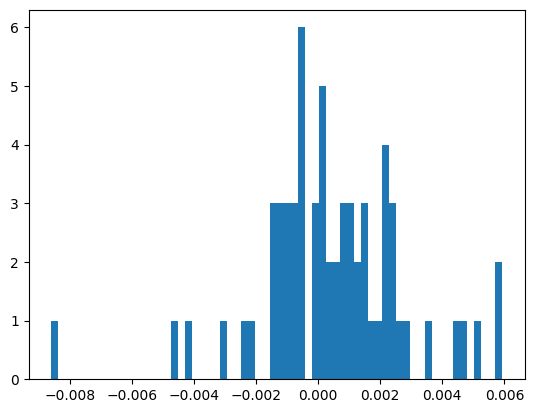

In [ ]:
plt.hist(test2, bins=64)
plt.show()

In [ ]:
order = np.argsort(test2)
print(channel_names[order])

['T8' 'FT8' 'C4' 'FC6' 'FT7' 'T7' 'FC4' 'F8' 'AF7' 'C6' 'C5' 'P10' 'F6'
 'CP6' 'AF8' 'CPz' 'CP4' 'F7' 'C2' 'TP8' 'CP2' 'TP7' 'Fp2' 'P1' 'FC5' 'Cz'
 'CP5' 'P9' 'P8' 'Fp1' 'P6' 'CP3' 'C1' 'Fpz' 'F2' 'P4' 'P2' 'C3' 'CP1'
 'F4' 'FC3' 'AF4' 'P7' 'FC2' 'PO8' 'FCz' 'Iz' 'FC1' 'AF3' 'F1' 'F3' 'AFz'
 'Fz' 'Pz' 'P5' 'F5' 'P3' 'PO4' 'O2' 'POz' 'PO7' 'Oz' 'PO3' 'O1']


In [ ]:
print(kurtosis(test2))
print(skew(test2))

2.4914447315150214
-0.5158940691864934
